In [42]:
import numpy as np
import torch 
import tudatpy 
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline

import math
import matplotlib.pyplot as plt
g = 9.81

In [21]:
def pendulum_eom(time, state, m, l): 
    '''
    Return the RHS of the ODE describing a pendulum in terms of an angle
    '''
    angle, angle_dot = state[0], state[1]
    
    d_angle = angle_dot
    d_angle_dot = -g * np.sin(angle)/l
    
    return np.array([d_angle, d_angle_dot]) 

In [168]:
def pendulum_hamiltonian(states, m, l):  
    '''
    Return the hamiltonian of a 2D-pendulum in terms of canonical coodinates
    '''
    
    q, p = states[..., 0], states[..., 1]
    T = (p**2)/(2*m*l**2)
    V = m*g*l*(1 - np.cos(q)) 
    
    return T+V

def pendulum_hamilton(time, state, m, l): 
    '''
    Return the hamilton equations of a 2D-pendulum in terms of canonical coodinates
    '''
    
    q, p = state[0], state[1] 
    dqdt = p/(m*l**2)
    dpdt = -m * g * l * np.sin(q)

    return np.array([dqdt, dpdt]) 

def gen_to_can(gen, m, l): 
    '''
    Convert the generlised coordinates to the canonical coordinates for 
    a 2D-pendulum
    '''
    
    can = np.zeros(gen.shape)
    can[:,0:2] = gen[:,0:2]
    can[:,2]  = gen[:,2] / (m*l**2) 
    
    return can

In [172]:
def integrate(fun, y0, t0, tf, method = "rk45", step_size = None, rtol = 1e-8, atol = 1e-8, args=None): 
    '''
    Integrate an arbitrary initial value problem with several methods
    '''
    
    if method == "euler": 
        assert  step_size != None,"Time step is not set"
        states, evals = euler(fun, y0, t0, tf, step_size, args)
        
    if method == "rk4": 
        assert  step_size != None,"Time step is not set"
        states, evals = rk4(fun, y0, t0, tf, step_size, args)
        
    if method == "leapfrog": 
        assert  step_size != None,"Time step is not set"
        states, evals = leapfrog(fun, y0, t0, tf, step_size, args)
        
    if method == "rk45": 
        states, evals = solve_ivp_wrapper(fun, y0, t0, tf, rtol = rtol, method = "RK45", atol = atol, args=args)
        
    if method == "dop853": 
        states, evals = solve_ivp_wrapper(fun, y0, t0, tf, rtol = rtol, method = "DOP853", atol = atol, args=args)
        
    return states, evals
        
def euler(fun, y0, t0, tf, step_size, args): 
    '''
    Solve an IVP with the euler method
    '''
    
    # Prepare integration
    steps = math.ceil((tf - t0)/step_size)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = len(times) - 1 
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        states[i+1, 0] = time
        states[i+1,1:] = states[i,1:] + step_size * fun(time, states[i,1:], *args) 
    
    return states, evals

def rk4(fun, y0, to, tf, h, args): 
    '''
    Solve an IVP with the euler method
    '''
    
    # Prepare integration
    steps = math.ceil((tf - t0)/h)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = 4*(len(times) - 1)
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        states[i+1, 0] = time
        k1 = fun(time, states[i,1:], *args) 
        k2 = fun(time + h/2, states[i,1:] + h*k1/2, *args)
        k3 = fun(time + h/2, states[i,1:] + h*k2/2, *args)
        k4 = fun(time + h, states[i,1:] + h*k3, *args) 
        
        states[i+1,1:] = states[i,1:] + (1./6.)*(k1 + 2*k2 + 2*k3 + k4)*h
    
    return states, evals


def leapfrog(hamilton_eqn, y0, t0, tf, h, args): 
    '''
    Implementation of the leapfrog integrator: a 2nd order symplectic integrator.
    
    Arguments:
        hamilton_eqn (function): this should be the Hamilton equations, which returns 
                                 a ndarray with 2d elements, where d is the 
                                 amount of generalized coordinates. The first d elements
                                 are dT/dp and the second d elements are -dV/dq. Note that 
                                 the Hamiltonian is required to be serarable! Fun should
                                 have signutare: fun(time, y, *args). 
        y0 (ndarray):            Initial state with 2d elements where d is the amount of
                                 generalized coordinates.
        t0 (float):              Initial time
        tf (float):              Final time 
        h  (float):              Step size of the independent variable (time)
        args (list):             Additional arguments to pass to fun(time, y, args)   
    
    Returns: 
        states (ndarray): An array with the times in the first columns and the 
                          generlized coordinates solution in the subsequent d columns
                          and in the final d columns the conjugate momentum solution
        evals (int):      The amount of function evaluations either -dV/dq or dT/dp 
    '''
    
    # This is a temporary solution! Note that more 
    # calculations are performed than necesarry!
    d = len(y0)
    def dT(t, p, args): 
        state = np.append(np.zeros(int(d/2)), p)
        return hamilton_eqn(t, state, *args)[:int(d/2)]

    def dV(t, q, args):
        state = np.append(q, np.zeros(int(d/2)))
        return hamilton_eqn(t, state, *args)[int(d/2):] 
    
    # Prepare integration
    steps = math.ceil((tf - t0)/h)
    states = np.zeros((steps, len(y0)+1)) 
    times = np.linspace(t0, tf, steps) 
    states[0] = np.append([t0], y0)
    evals = 2*len(times) - 1 
    
    # Integrate 
    for i, time in enumerate(times[1:]):
        
        t_old = states[i,0]
        p_old = states[i, int(1+d/2):] 
        q_old = states[i,1:int(1+d/2)]
        
        p_temp = p_old + (1./2.) * h * dV(t_old, q_old, args) 
        q_new  = q_old + h * dT(t_old, p_temp, args) 
        p_new  = p_temp + (1./2.) * h * dV(t_old, q_new, args) 
        
        states[i+1, 0] = time
        states[i+1, 1:int(1+d/2)] = q_new
        states[i+1, 1+int(d/2):] = p_new

    return states, evals 


def solve_ivp_wrapper(fun, y0, to, tf, rtol = 1e-8, atol = 1e-8, args=None, method = "RK45"): 
    '''
    Solve an IVP with the RK4(5) integrator
    '''
    
    # Integrate
    result = solve_ivp(fun, (t0, tf), y0, atol=atol, rtol=rtol, method = method, args = args) 
    
    # Extract info
    time = result.t
    y = result.y
    evals = result.nfev
    
    # Put with time in array
    states = np.zeros((len(y[0]), len(y)+1))
    states[:,0] = time
    states[:,1:] = y.T
    
    return states, evals

In [195]:
l = 10
m = 10
y0 = np.array([np.pi/4, 0])
t0 = 0
tf = 10
time_step = 0.01

states_bench, evals_bench = integrate(pendulum_eom, y0, t0, tf, rtol = 1e-12, atol = 1e-12, method = "dop853", args = [l, m])
states_euler, evals_euler = integrate(pendulum_eom, y0, t0, tf, step_size = time_step, method = "euler", args = [l, m])
states_leapfrog, evals_leapfrog = integrate(pendulum_hamilton, y0, t0, tf, step_size = time_step, method = "leapfrog", args = [l, m])
states_symp_euler, evals_symp_euler = integrate(pendulum_hamilton, y0, t0, tf, step_size = time_step, method = "euler", args = [l, m])
states_rk4, evals_rk4 = integrate(pendulum_eom, y0, t0, tf, step_size = time_step, method = "rk4", args = [l, m])


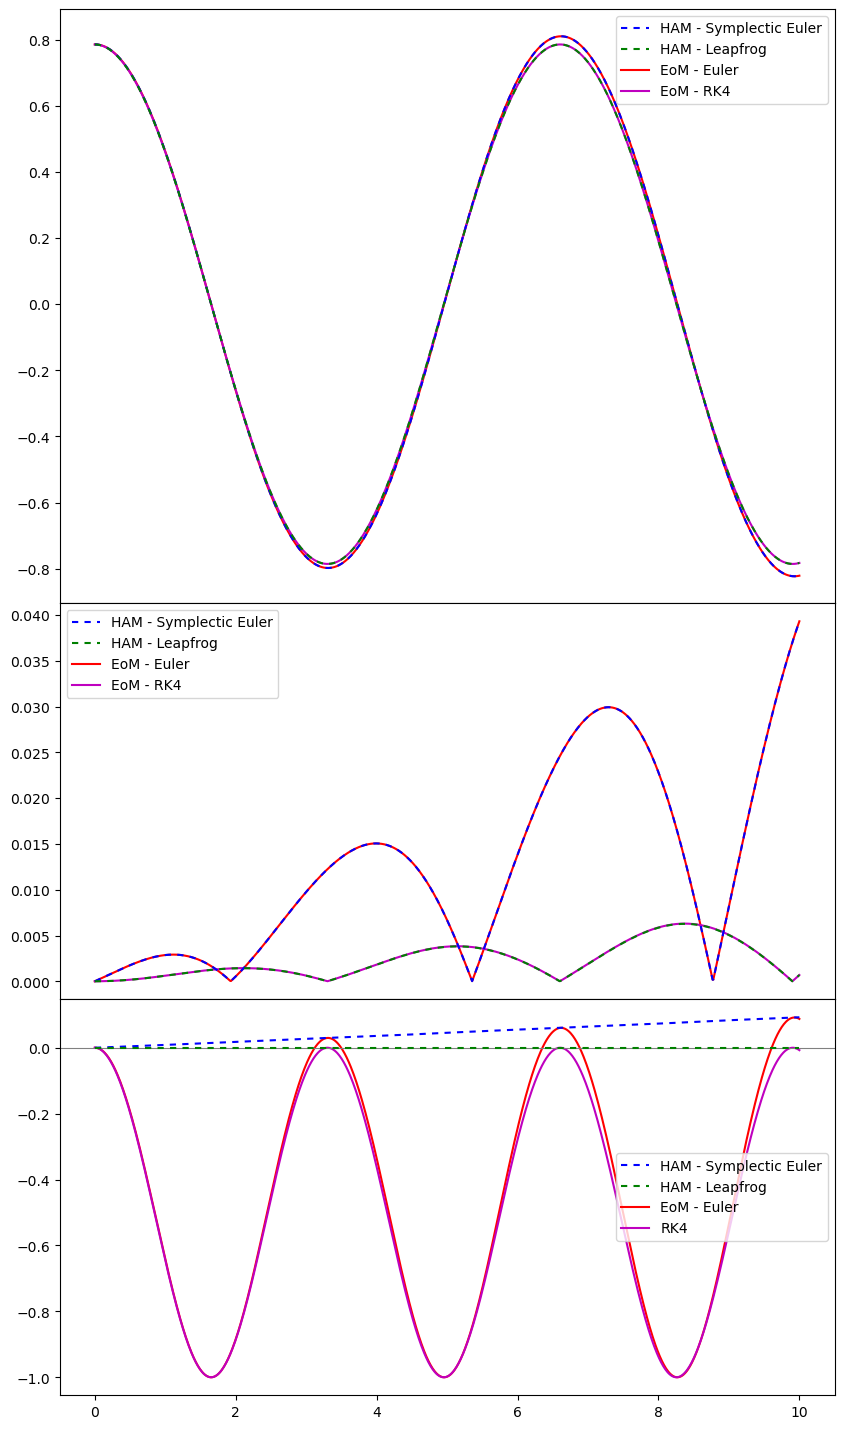

In [198]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18), sharex = True, gridspec_kw={'height_ratios': [3, 2, 2]}) 
fig.subplots_adjust(hspace=0)

axes[0].plot(states_symp_euler[:,0], states_symp_euler[:,1], linestyle = '--', zorder = 100, label = "HAM - Symplectic Euler", dashes = (3, 3), color = 'b')
axes[0].plot(states_leapfrog[:,0], states_leapfrog[:,1], linestyle = '--', zorder = 100, label = "HAM - Leapfrog", dashes = (3, 3), color = 'g')
axes[0].plot(states_euler[:,0], states_euler[:,1], label = "EoM - Euler", color = 'r')
axes[0].plot(states_rk4[:,0], states_rk4[:,1],  label = "EoM - RK4", color = 'm')
#axes[0].plot(states_bench[:,0], states_bench[:,1], linestyle = '--', zorder = 100, label = "Benchmark")
axes[0].legend()

cs = CubicSpline(states_bench[:,0], states_bench[:,1]) 
axes[1].plot(states_symp_euler[:,0], np.abs(states_symp_euler[:,1] - cs(states_symp_euler[:,0])), linestyle = '--', zorder = 100, label = "HAM - Symplectic Euler", color='b', dashes = (3, 3))
axes[1].plot(states_leapfrog[:,0], np.abs(states_leapfrog[:,1] - cs(states_leapfrog[:,0])),linestyle = '--', zorder = 100, label = "HAM - Leapfrog", color = 'g', dashes = (3, 3))
axes[1].plot(states_euler[:,0], np.abs(states_euler[:,1] - cs(states_euler[:,0])), label = "EoM - Euler", color = 'r')
axes[1].plot(states_rk4[:,0], np.abs(states_rk4[:,1] - cs(states_euler[:,0])), label = "EoM - RK4", color = 'm')
axes[1].legend()

H0_symp_euler = pendulum_hamiltonian(states_symp_euler[0,1:], m, l)
H0_leapfrog = pendulum_hamiltonian(states_leapfrog[0,1:], m, l)

H0_euler = pendulum_hamiltonian(gen_to_can(states_euler, m, l)[0,1:], m, l)
H0_rk4 = pendulum_hamiltonian(gen_to_can(states_rk4, m, l)[0,1:], m, l)

axes[2].plot(states_symp_euler[:,0], 
             (pendulum_hamiltonian(states_symp_euler[:,1:], m, l) - H0_symp_euler)/H0_symp_euler, 
             linestyle = '--', 
             zorder = 100, 
             label = "HAM - Symplectic Euler", 
             color = 'b', 
             dashes = (3, 3))

axes[2].plot(states_leapfrog[:,0], 
             (pendulum_hamiltonian(states_leapfrog[:,1:], m, l) - H0_leapfrog)/H0_leapfrog, 
             linestyle = '--', 
             zorder = 100, 
             label = "HAM - Leapfrog", 
             color = 'g', 
             dashes = (3, 3))

axes[2].plot(states_euler[:,0], 
             (pendulum_hamiltonian(gen_to_can(states_euler, m, l)[:,1:], m, l) - H0_euler)/H0_euler, 
             label = "EoM - Euler", 
             color = 'r')

axes[2].plot(states_rk4[:,0],
             (pendulum_hamiltonian(gen_to_can(states_rk4, m, l)[:,1:], m, l) - H0_rk4)/H0_rk4,
             label = "RK4", 
             color = 'm')
axes[2].axhline(0, linewidth=0.8, color = 'grey')

#axes[2].plot(states_bench[:,0], pendulum_hamiltonian(gen_to_can(states_bench, m, l)[:,1:], m, l), label = "Benchmark")
#axes[2].set_yscale("symlog")
axes[2].legend()